In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from preprocessor.data_preprocessor import LeadScoringPreprocessor

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, roc_auc_score, precision_score, precision_recall_curve, PrecisionRecallDisplay, confusion_matrix, classification_report, roc_curve

from xgboost import XGBClassifier

## 1. Import Data

In [7]:
df = pd.read_csv('data/lead_scoring.csv')

In [8]:
X = df.drop('Converted', axis=1)
y = df['Converted']

#### Split data to train test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 2. Preprocess data

In [10]:
preprocessor = LeadScoringPreprocessor()
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

['Lead Origin', 'Lead Source', 'Do Not Email', 'Last Activity', 'Specialization', 'What is your current occupation']
['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']


## 3. Training Utils

#### Cross Validation

In [11]:
skfold = StratifiedKFold(5, shuffle=True, random_state=12)

#### Display Cross Validation Score

In [12]:
def display_scores(model,scores,pred):
  print(f'----------- {model} -----------')
  print('')
  print("------------------ Cross validation scores:")
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())
  print('')
  print("--------------- Scores in the training set:")
  print("Precision:", precision_score(y_train,pred))
  print("Recall:", recall_score(y_train,pred))
  print("F1 score:", f1_score(y_train,pred))
  print("ROC - AUC score:", roc_auc_score(y_train,pred))

## 4. Modelling with XGBoost

### 4.1. Initial Model

In [13]:
# init model
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss', # Or 'auc' for Area Under ROC Curve
    use_label_encoder=False, # Suppresses a warning in newer versions
    random_state=42
)

In [14]:
# cross validation score
xgb_scores = cross_val_score(xgb_model, X_train, y_train,
                            cv=skfold, scoring='f1')

##### Model Training

In [15]:
# Train the model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

##### Evaluate

In [16]:
# Prediction on training set
xgb_pred = xgb_model.predict(X_train)

# Prediction on test set
y_pred = xgb_model.predict(X_test)

In [24]:
# Display Scores
display_scores('XGBoost',xgb_scores,xgb_pred)

----------- XGBoost -----------

------------------ Cross validation scores:
Scores: [0.77316858 0.77448338 0.77484047 0.75940507 0.76283186]
Mean: 0.7689458728087247
Standard deviation: 0.006506143936148424

--------------- Scores in the training set:
Precision: 0.8868267831149927
Recall: 0.8553878553878553
F1 score: 0.870823655529748
ROC - AUC score: 0.893465444312902


In [19]:
# Calculate lead scores
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
lead_scores = y_pred_proba * 100

In [22]:
# Precision and recall curve
xgb_prec, xgb_recall, xgb_threshold = precision_recall_curve(y_train, xgb_pred, pos_label=xgb_model.classes_[1])
xgb_prdisplay = PrecisionRecallDisplay(precision=xgb_prec, recall=xgb_recall)

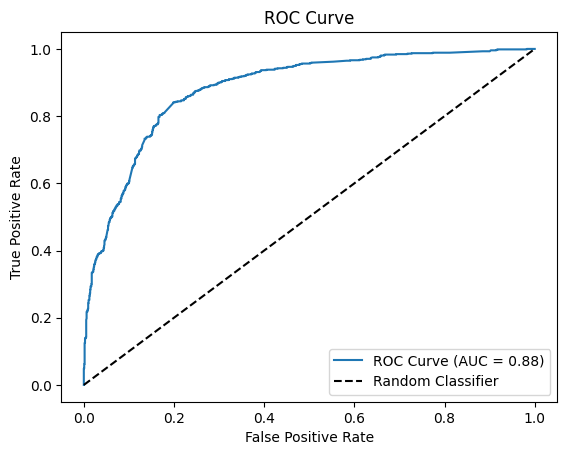

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Text(120.72222222222221, 0.5, 'True')

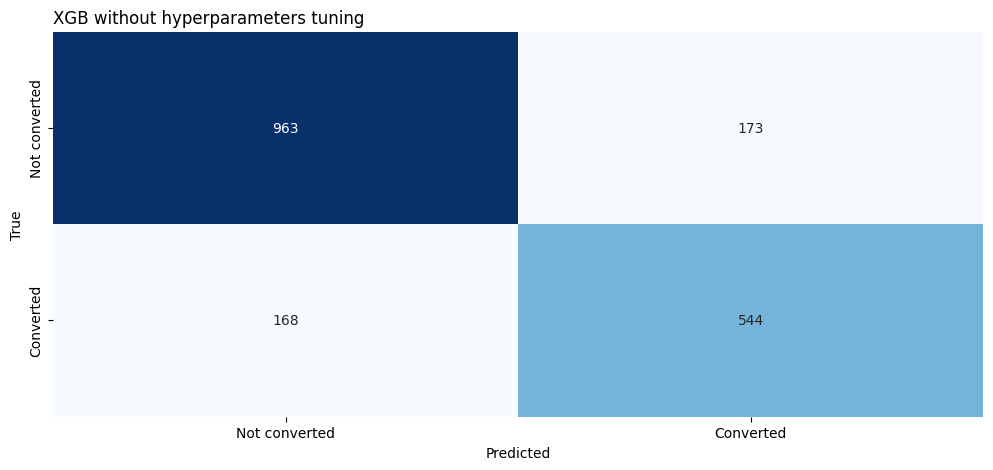

In [20]:
fig, ax = plt.subplots(figsize=(12, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
ax.xaxis.set_ticklabels(['Not converted', 'Converted'])
ax.yaxis.set_ticklabels(['Not converted', 'Converted'])
ax.set_title('XGB without hyperparameters tuning', loc='left')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

##### Feature Importances

In [21]:
# Get feature names from the preprocessor
feature_names = preprocessor.get_feature_names()

                                              feature  importance
2               pipeline-1__Lead Origin_Lead Add Form    0.487392
48  pipeline-1__What is your current occupation_Wo...    0.071626
47  pipeline-1__What is your current occupation_Un...    0.054088
23           pipeline-1__Last Activity_SMS/Email Sent    0.052708
14                         pipeline-1__Do Not Email_0    0.024047
50            pipeline-2__Total Time Spent on Website    0.019162
20  pipeline-1__Last Activity_Olark Chat Conversation    0.017170
43  pipeline-1__What is your current occupation_Ho...    0.011546
18             pipeline-1__Last Activity_Email Opened    0.011191
3                 pipeline-1__Lead Origin_Lead Import    0.010615
45  pipeline-1__What is your current occupation_St...    0.010282
41                 pipeline-1__Specialization_Unknown    0.010276
16        pipeline-1__Last Activity_Converted to Lead    0.009763
1     pipeline-1__Lead Origin_Landing Page Submission    0.009733
49        

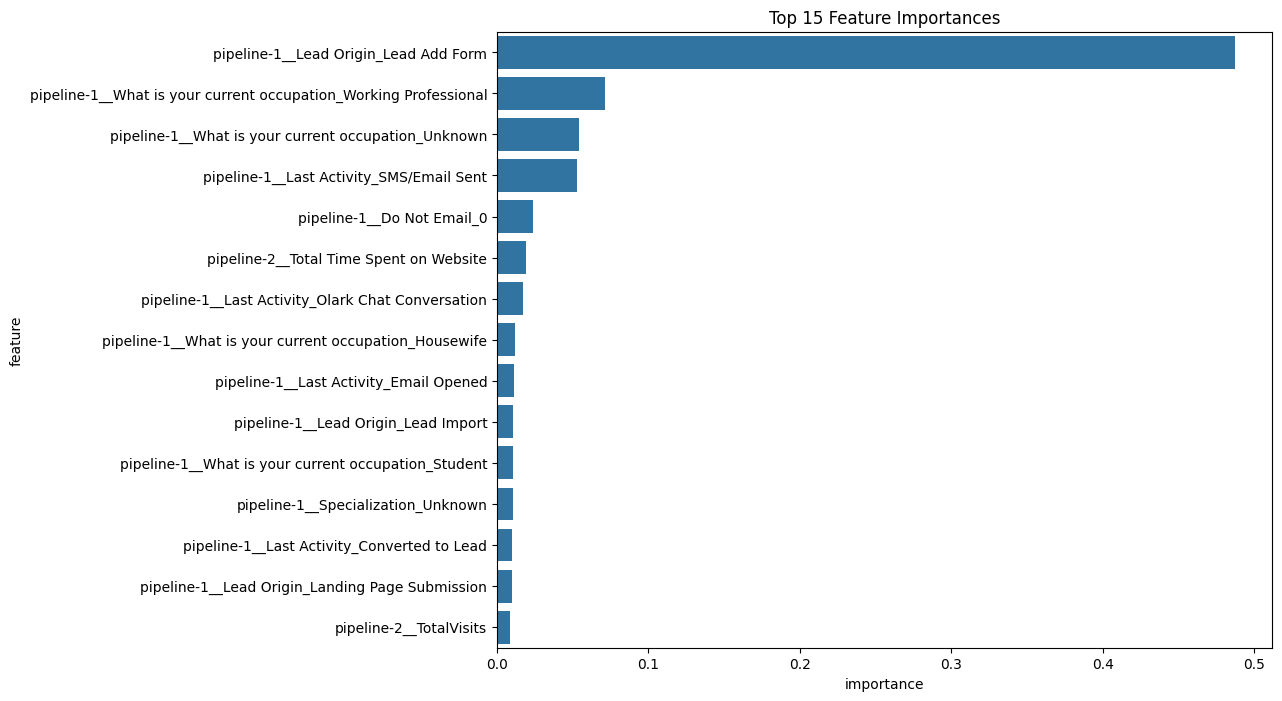

In [22]:
feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importances)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(15))
plt.title('Top 15 Feature Importances')
plt.show()

### 4.2. Fine-tuning XGBoost